# ▒ 선형회귀분석 ▒

## 0. 환경설정

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

## 1. 단순선형회귀분석의 적합

### 1-1. Sale 데이터를 이용한 단순선형회귀분석

In [14]:
data_file = "./data/Sales.csv"
Sales = pd.read_csv(data_file)
Sales.iloc[0:5]

,Company,Adver,Sales
0,1,11,23
1,2,19,32
2,3,23,36
3,4,26,46
4,5,56,93


In [11]:
## 단순선형회귀분석 적합
SalesFit = smf.ols(formula='Sales~Adver', data=Sales).fit()
print(SalesFit.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     455.5
Date:                Mon, 23 May 2022   Prob (F-statistic):           1.14e-09
Time:                        13:17:56   Log-Likelihood:                -32.059
No. Observations:                  12   AIC:                             68.12
Df Residuals:                      10   BIC:                             69.09
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.2848      2.889      1.137      0.2

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


In [15]:
## 적합된 모형을 이용한 적합값 및 신뢰구간
predictions = SalesFit.get_prediction()
predictions.summary_frame(alpha=0.05).round(3).iloc[0:3]

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,20.854,2.152,16.058,25.649,11.057,30.650
1,33.631,1.667,29.916,37.346,24.316,42.946
2,40.019,1.457,36.773,43.266,30.881,49.158


## 2. 잔차분석
### 2-1. 표준화잔차와 잔차도표

In [24]:
Fitted = SalesFit.predict()
Residual = SalesFit.resid
RStandard = SalesFit.resid_pearson

## 잔차, 표준화잔차의 탐색
pd.DataFrame({'Fitted': Fitted, 'Residual': Residual, \
                    'RStandard': RStandard}).iloc[0:5]

,Fitted,Residual,RStandard
0,20.853505,2.146495,0.559896
1,33.630747,-1.630747,-0.425367
2,40.019368,-4.019368,-1.048420
3,44.810833,1.189167,0.310185
4,92.725489,0.274511,0.071604


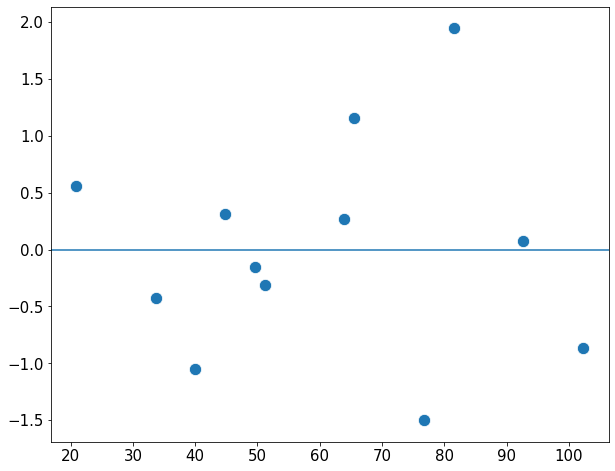

In [36]:
## 잔차 도표
fig, ax = plt.subplots(figsize=(10,8))
sns.scatterplot(x=Fitted,y=RStandard, s=150)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.axhline(y=0)

### 2-2. 정규성 검토

((array([-1.58815464, -1.09814975, -0.78255927, -0.53069113, -0.30892353,
         -0.101534  ,  0.101534  ,  0.30892353,  0.53069113,  0.78255927,
          1.09814975,  1.58815464]),
  array([-1.50086884, -1.04842015, -0.86297515, -0.42536736, -0.31286804,
         -0.15710484,  0.07160403,  0.26692088,  0.31018475,  0.55989614,
          1.15452596,  1.94447261])),
 (1.014930164527946, 6.532364655292017e-15, 0.9869321023876498))

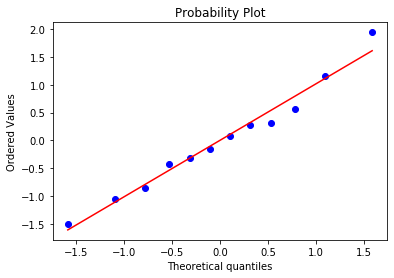

In [43]:
from scipy.stats import probplot
## Q-Q plot
probplot(RStandard, plot=plt)

### 2-3. 독립성 가정 검토 (더빈-왓슨 통계량)

In [44]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson(RStandard).round(5)

2.47031

- 더빈-왓슨 통계량의 값은 약 2.470
- 비교적 2에 가까워서 독립성 가정에 큰 문제가 없음.

## 3. 다변량회귀분석모형의 적합
### 데이터 준비

- 700명의 고객을 대상으로 어떤 제품에 대해 조사하여 얻은 데이터.
- $X_1$: 디자인 만족도
- $X_2$: 사용 편리성 만족도
- $X_3$: 성능 만족도
- $X_4$: 고장 및 경고성 만족도
- $Gender$: 성별 (1:남자, 2:여자)
- $Age$: 나이 (1: 10대, 2:20대, $\ldots$)
- $Y$: 구입 의향 점수



### 데이터 호출
- 500개, 200개의 두 데이터셋으로 나누어 하나는 훈련 자료, 하나는 시험 자료로 사용.

In [3]:
data_file = "./data/Satisfaction.csv"
Satisfaction = pd.read_csv(data_file)

Tr_Sat = Satisfaction.iloc[1:500,:]
Ts_Sat = Satisfaction.iloc[500:700,:]

,Y,X1,X2,X3,X4,Gender,Age
1,5,5,5,5,5,1,5
2,5,5,6,5,5,2,5
3,5,6,6,5,6,1,2
4,5,5,6,5,5,1,5
5,9,5,5,5,5,2,5
...,...,...,...,...,...,...,...
495,6,6,6,6,6,1,5
496,4,6,5,4,4,2,1
497,5,6,5,5,5,2,1
498,4,5,5,5,4,2,1


### 3-1. 모형 적합하기
- Age, Gender는 범주형 변수.
- C()를 사용하여 모형을 범주현 변수로 취급할 수 있음.

In [18]:
SatFit = smf.ols(formula='Y~X1+X2+X3+X4+C(Age)+ \
                 C(Gender)', data=Tr_Sat).fit()

In [19]:
## 적합 모형의 전체 정보
print(SatFit.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     10.38
Date:                Mon, 23 May 2022   Prob (F-statistic):           9.78e-15
Time:                        13:42:28   Log-Likelihood:                -783.24
No. Observations:                 499   AIC:                             1586.
Df Residuals:                     489   BIC:                             1629.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.6812      0.424      3.

In [7]:
## 적합 모형의 추정 계수 정보만 따로 추출
print(SatFit.params.round(5))

Intercept         1.68115
C(Age)[T.2]      -0.27592
C(Age)[T.3]      -0.33035
C(Age)[T.4]      -0.13041
C(Age)[T.5]      -0.06705
C(Gender)[T.2]    0.19021
X1                0.12487
X2                0.05236
X3                0.38463
X4                0.06871
dtype: float64


In [39]:
SatFit2 = smf.ols(formula='Y~X1+X2+X3+X4+\
                 C(Age, Treatment(reference=5))+ \
                 C(Gender, Treatment(reference=2))', \
                  data=Tr_Sat).fit()

In [41]:
print(SatFit2.params.round(5))

Intercept                                 1.80431
C(Age, Treatment(reference=5))[T.1]       0.06705
C(Age, Treatment(reference=5))[T.2]      -0.20886
C(Age, Treatment(reference=5))[T.3]      -0.26329
C(Age, Treatment(reference=5))[T.4]      -0.06335
C(Gender, Treatment(reference=2))[T.1]   -0.19021
X1                                        0.12487
X2                                        0.05236
X3                                        0.38463
X4                                        0.06871
dtype: float64


In [21]:
## 예측해보기
predictions = SatFit.get_prediction(Ts_Sat)
predictions.summary_frame(alpha=0.05).round(3).iloc[0:3]

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,4.817,0.136,4.549,5.085,2.494,7.140
1,4.585,0.182,4.228,4.943,2.250,6.921
2,5.324,0.146,5.037,5.612,2.999,7.650
